In [131]:
%matplotlib inline

import urllib
import os
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import movingpandas as mpd
import datatable as dt
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.pandas
import folium

from folium.plugins import HeatMap
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
from datetime import datetime, timedelta
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from holoviews import opts
from sklearn.preprocessing import StandardScaler
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))

import warnings
warnings.simplefilter("ignore")
CRS_METRIC = from_epsg(4326)

In [134]:
def create_datasets(df, lookback, target_size, single_step):
    # normalize the input
#     input_data = df.iloc[:, [0, 1]].values
    input_data = df.iloc[:, [0, 1]].values

    X = []
    y = []
    start_index = lookback
    end_index = len(input_data) - target_size
    for i in range(start_index, end_index):
        indices = range(i-lookback, i)
        X.append(input_data[indices])
        if single_step:
            y.append(input_data[i + target_size - 1, :])
        else:
            y.append(input_data[i:i + target_size, :].reshape(target_size*2))
    return X, y

def merge_with_mmsi(data, df):
    df_data = pd.DataFrame(data)
    df_data['mmsi'] = df.reset_index()['mmsi']

    return df_data

def generate_all_datasets(df, history_size, target_size, single_step):
    X = []
    y = []

    idx_list = df['mmsi'].value_counts().index.tolist()

    for mmsi in idx_list:
        data_temp = df.loc[df['mmsi'] == mmsi]
        X_temp, y_temp = create_datasets(data_temp, history_size, target_size, single_step)
        X.extend(X_temp)
        y.extend(y_temp)
    return np.array(X), np.array(y)

def create_test_set(df, past_history, future_target):
    uni_values = df.iloc[:, [2, 3]].values
#     uni_values = df.iloc[:, [-3, -2]].values
    
    train_size_temp = int(len(uni_values) * 0.8)
    test_size = len(uni_values) - train_size_temp
    valid_size = int(train_size_temp * 0.25)
    train_size = train_size_temp - valid_size

    train_temp, test = uni_values[:train_size_temp, :], uni_values[train_size_temp:len(uni_values), :]
    train, valid = train_temp[:train_size, :], train_temp[train_size:train_size_temp, :]

    df_train_temp, df_test = df[:train_size_temp], df[train_size_temp:len(uni_values)]
    df_train, df_valid = df[:train_size], df[train_size:train_size_temp]

    sc_train = StandardScaler().fit(train)
    train_norm = sc_train.transform(train)
    valid_norm = sc_train.transform(valid)
    test_norm = sc_train.transform(test)

    # create datasets
#     data_train = merge_with_mmsi(train_norm, df_train)
#     data_valid = merge_with_mmsi(valid_norm, df_valid)
    data_test = merge_with_mmsi(test_norm, df_test)
    
#     print(data_test.loc[0:5, :])
    
#     x_train_single, y_train_single = generate_all_datasets(data_train, past_history, future_target, False)
#     x_val_single, y_val_single = generate_all_datasets(data_valid, past_history, future_target, False)
    x_test_single, y_test_single = generate_all_datasets(data_test, past_history, future_target, False)
#     print('\nX train shape: {}, y train shape: {} '.format(x_train_single.shape, y_train_single.shape))
#     print('\nX valid shape: {}, y valid shape: {} '.format(x_val_single.shape, y_val_single.shape))
    print('\nX test shape: {}, y test shape: {} '.format(x_test_single.shape, y_test_single.shape))
    return x_test_single, y_test_single, sc_train

def inverse_to_df(data, sc):
    data_inverse = sc.inverse_transform(data)
    df_data = pd.DataFrame(data_inverse)
    df_data.rename(columns={0:'lon', 1:'lat'}, inplace=True)    
    return df_data

def generateBaseMap(default_location=[1.22437, 103.78520], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

def plotDot(rows, index, color, m):
    folium.Marker([rows.lat, rows.lon], radius=10, icon=folium.Icon(color=color), tooltip=index).add_to(m)
#     folium.Circle([rows.lat, rows.lon], radius=5, color=color, fill=True).add_to(m)
    return m

def showMap(df, m, color):
    for index, rows in df.iterrows():
        m = plotDot(rows, index, color, m)
    return m

def plot_predict(target, pred, history):
    themap = generateBaseMap()
    m = showMap(history, themap, 'blue')
    m = showMap(target, m, 'red')
    m = showMap(pred, m, 'green')
    return m

def plot_predict_all(target, pred):
    themap = generateBaseMap()
    m = showMap(target, themap, 'red')
    m = showMap(pred, m, 'green')
    return m

def show_traj(idx, x, y, pred, sc):
    return plot_predict(inverse_to_df(y[idx], sc), 
                        inverse_to_df(pred[idx], sc), 
                        inverse_to_df(x[idx], sc))

def show_traj_all(start, end):
    return plot_predict_all(inverse_to_df(y_test[start:end], scaler), 
                            inverse_to_df(prediction[idx:end], scaler))

def recurrent_predict(x_test, idx, lookback, target):
    steps, feats = x_test.shape[-2:]
    inp = x_test[idx].reshape(1, steps, feats)
    preds = []

    end_index = 30//target

    for i in range(0, end_index):
        inp = inp.reshape(1,steps,feats)
        pred = model.predict(inp).reshape(10, 2)
        preds.extend(pred.tolist())
        inp = inp.reshape(steps,feats).tolist()
        if i == end_index-1:
            break
#         if ((i+1)*10 == lookback):
#         inp = pred
#         else:
        inp = np.append(inp[(i+1)*10:lookback], preds, axis=0)
    return preds

def generate_targets(idx, lookback, target):
    targets = []
    for i in range(1,(30//target)+1):
        target = y_test[idx+(i-1)*10]
        targets.extend(target)
    return targets

def show_traj_recc(idx, lookback, target):
    return plot_predict(inverse_to_df(generate_targets(idx, lookback, target), scaler), 
                        inverse_to_df(recurrent_predict(x_test, idx, lookback, target), scaler), 
                        inverse_to_df(x_test[idx], scaler))

def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1))

def mae(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.abs(y_pred - y_true), axis=-1)

def mape(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.abs((y_pred - y_true)/y_true), axis=-1) * 100

In [135]:
df = pd.read_csv('final_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print('finished reading {} records'.format(len(df)))

finished reading 2508510 records


In [136]:
df.head()

time       mmsi         lon       lat
0  2019-12-01 00:22:00  205408000  103.538121  1.181544
1  2019-12-01 00:23:00  205408000  103.539436  1.181869
2  2019-12-01 00:24:00  205408000  103.540592  1.182298
3  2019-12-01 00:25:00  205408000  103.541742  1.182730
4  2019-12-01 00:26:00  205408000  103.542892  1.183162

In [53]:
x_test, y_test, scaler = create_test_set(df, 30, 1)


X test shape: (485427, 30, 2), y test shape: (485427, 2) 


In [137]:
import tensorflow as tf

In [159]:
def load_model_history(model, history):
#     model = tf.keras.models.load_model(model, custom_objects={'rmse':rmse})
    model = tf.keras.models.load_model(model)
    history = np.load(history, allow_pickle=True).item()
    return model, history

In [160]:
def plot_loss(history, param='loss'):
    loss = history[param]
    val_loss = history['val_'+param]

    epochs = range(len(loss))

    plt.clf()
    plt.plot(epochs, loss, 'b', label='Training '+param)
    plt.plot(epochs, val_loss, 'r', label='Validation '+param)
    plt.title('Training and validation '+param)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [162]:
def load_and_plot(name, df, hist, future):
    x, y, scaler = create_test_set(df, hist, future)
    model, history = load_model_history(name+'.hdf5', name+'.npy')
#     plot_loss(history, 'rmse')
#     plot_loss(history, 'mape')
#     plot_loss(history)
#     test_loss = model.evaluate(x, y, batch_size=256)
#     print('test loss :', test_loss)
    return model, x, y, scaler

### Plot training loss


X test shape: (485427, 30, 2), y test shape: (485427, 2) 


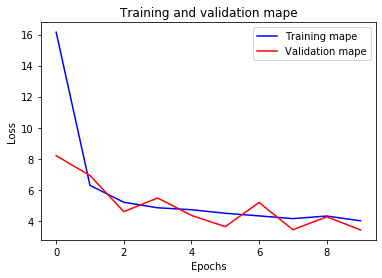

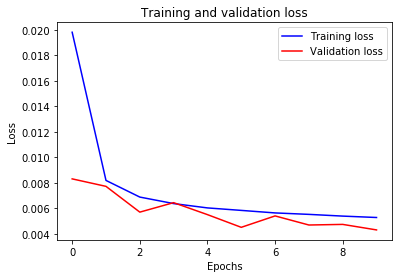

485427/485427 [==============================] - 41s 84us/sample - loss: 0.0049 - mape: 3.5080
test loss : [0.00494075026450736, 3.5080135]


In [401]:
model301, x_test301, y_test301, scaler301 = load_and_plot('single_step_30_1_3lstm', 30, 1)

In [402]:
prediction301 = model301.predict(x_test301)
# samples, size = prediction301.shape
# prediction301 = prediction301.reshape(samples, size//2, 2)
# y_test301 = y_test301.reshape(samples, size//2, 2)

In [404]:
np.mean(rmse(prediction301, y_test301)), np.mean(mae(prediction301, y_test301))

(0.005635614747300176, 0.004940750342245725)


X test shape: (490677, 20, 2), y test shape: (490677, 2) 


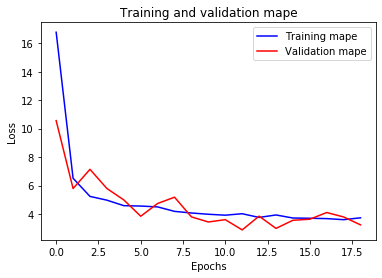

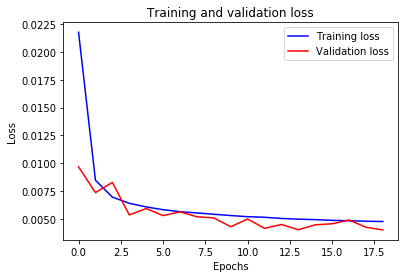

490677/490677 [==============================] - 28s 56us/sample - loss: 0.0047 - mape: 3.5691
test loss : [0.004709294091817678, 3.569136]


In [405]:
model201, x_test201, y_test201, scaler201 = load_and_plot('single_step_20_1_3lstm', 20, 1)

In [407]:
prediction201 = model201.predict(x_test201)

np.mean(rmse(prediction201, y_test201)), np.mean(mae(prediction201, y_test201))

(0.005363292247491285, 0.004709294016017794)


X test shape: (495927, 10, 2), y test shape: (495927, 2) 


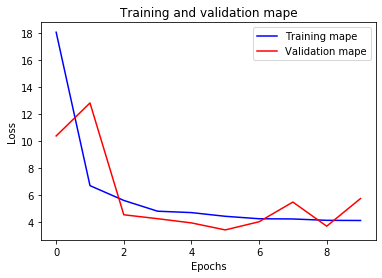

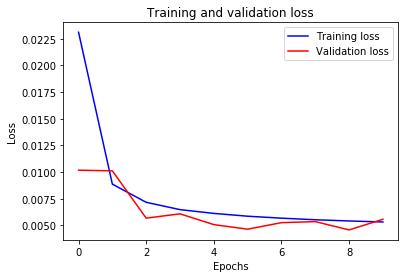

495927/495927 [==============================] - 13s 27us/sample - loss: 0.0063 - mape: 4.3730
test loss : [0.006267993425130051, 4.373038]


In [408]:
model101, x_test101, y_test101, scaler101 = load_and_plot('single_step_10_1_3lstm', 10, 1)

In [409]:
prediction101 = model101.predict(x_test101)

np.mean(rmse(prediction101, y_test101)), np.mean(mae(prediction101, y_test101))

(0.0070470622971026955, 0.006267993404895392)


X test shape: (500652, 1, 2), y test shape: (500652, 2) 


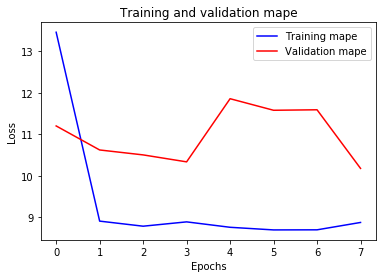

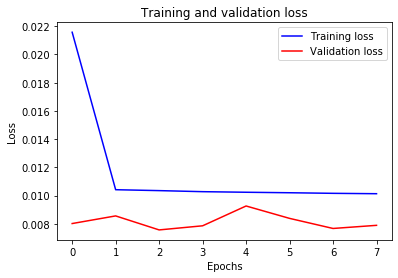

500652/500652 [==============================] - 4s 8us/sample - loss: 0.0101 - mape: 8.5336
test loss : [0.010092321170696755, 8.53359]


In [410]:
model11, x_test11, y_test11, scaler11 = load_and_plot('single_step_1_1_3lstm', 1, 1)

In [411]:
prediction11 = model11.predict(x_test11)

np.mean(rmse(prediction11, y_test11)), np.mean(mae(prediction11, y_test11))

(0.011215218411150469, 0.010092321164040624)


X test shape: (456715, 80, 2), y test shape: (456715, 20) 


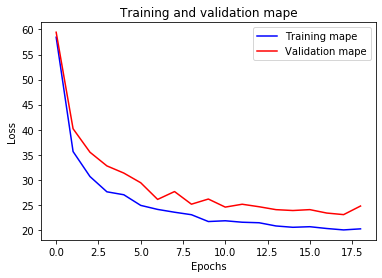

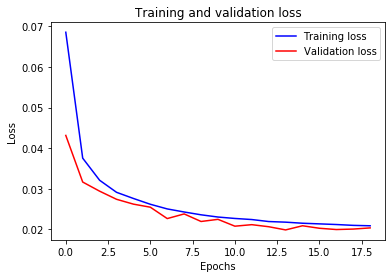

456715/456715 [==============================] - 104s 228us/sample - loss: 0.0244 - mape: 20.8569
test loss : [0.024389929813570674, 20.856863]


(0.0342053304828159, 0.024389930008067755)

In [430]:
model8010, x_test8010, y_test8010, scaler8010 = load_and_plot('retry_multi_step_80_10_4lstm_32', df, 80, 10)

prediction8010 = model8010.predict(x_test8010)
np.mean(rmse(prediction8010, y_test8010)), np.mean(mae(prediction8010, y_test8010))


X test shape: (465871, 60, 2), y test shape: (465871, 20) 


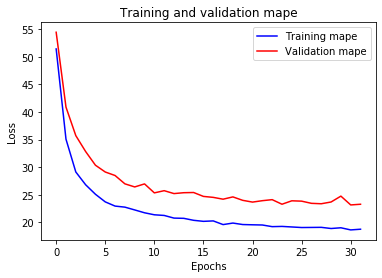

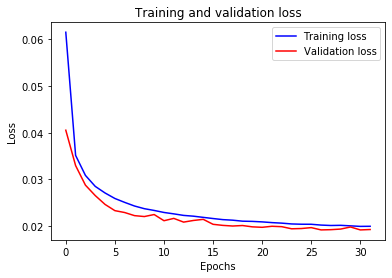

465871/465871 [==============================] - 69s 148us/sample - loss: 0.0229 - mape: 19.9757
test loss : [0.02289272992549269, 19.975716]


(0.03268330871267627, 0.0228927299264477)

In [424]:
model6010, x_test6010, y_test6010, scaler6010 = load_and_plot('retry_multi_step_60_10_3lstm_32', df, 60, 10)

prediction6010 = model6010.predict(x_test6010)
np.mean(rmse(prediction6010, y_test6010)), np.mean(mae(prediction6010, y_test6010))


X test shape: (475645, 40, 2), y test shape: (475645, 20) 


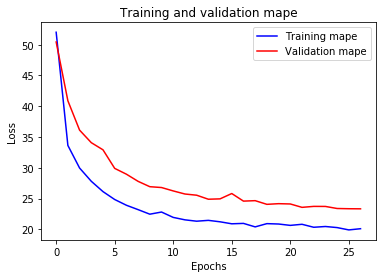

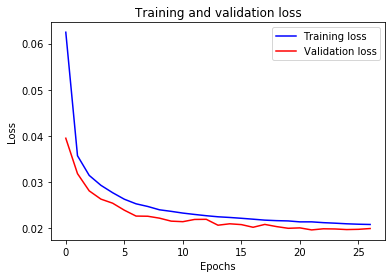

475645/475645 [==============================] - 47s 99us/sample - loss: 0.0238 - mape: 20.0455
test loss : [0.02383531584816386, 20.045475]


(0.033938840338280096, 0.023835315857261903)

In [425]:
model4010, x_test4010, y_test4010, scaler4010 = load_and_plot('retry_multi_step_40_10_3lstm_32', df, 40, 10)

prediction4010 = model4010.predict(x_test4010)
np.mean(rmse(prediction4010, y_test4010)), np.mean(mae(prediction4010, y_test4010))


X test shape: (480736, 30, 2), y test shape: (480736, 20) 


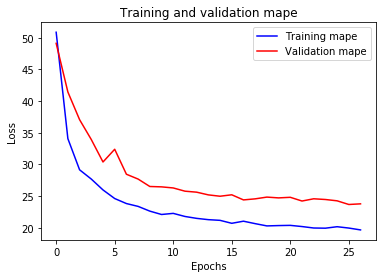

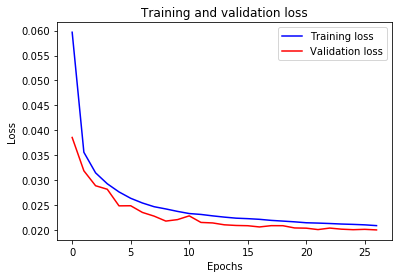

480736/480736 [==============================] - 37s 78us/sample - loss: 0.0240 - mape: 20.0567
test loss : [0.02398129184748019, 20.05669]


(0.03402374631559929, 0.02398129174394188)

In [426]:
model3010, x_test3010, y_test3010, scaler3010 = load_and_plot('retry_multi_step_30_10_3lstm_32', df, 30, 10)

prediction3010 = model3010.predict(x_test3010)
np.mean(rmse(prediction3010, y_test3010)), np.mean(mae(prediction3010, y_test3010))


X test shape: (485952, 20, 2), y test shape: (485952, 20) 


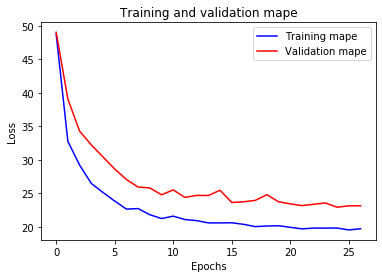

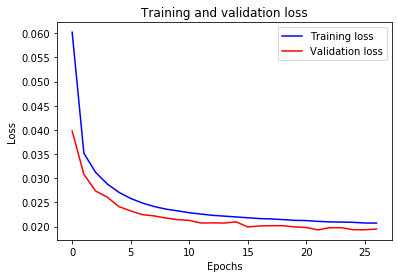

485952/485952 [==============================] - 26s 53us/sample - loss: 0.0234 - mape: 19.6873
test loss : [0.023430506900279396, 19.687346]


(0.03332574757561347, 0.023430506704408872)

In [427]:
model2010, x_test2010, y_test2010, scaler2010 = load_and_plot('retry_multi_step_20_10_3lstm_32', df, 20, 10)

prediction2010 = model2010.predict(x_test2010)
np.mean(rmse(prediction2010, y_test2010)), np.mean(mae(prediction2010, y_test2010))


X test shape: (491202, 10, 2), y test shape: (491202, 20) 


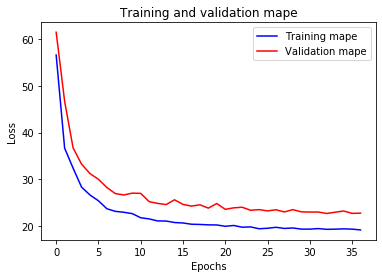

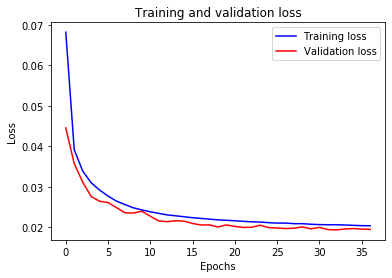

491202/491202 [==============================] - 15s 30us/sample - loss: 0.0233 - mape: 19.1035
test loss : [0.023283770621175807, 19.103529]


(0.03319924909633673, 0.023283770769351723)

In [428]:
model1010, x_test1010, y_test1010, scaler1010 = load_and_plot('retry_multi_step_10_10_3lstm_32', df, 10, 10)

prediction1010 = model1010.predict(x_test1010)
np.mean(rmse(prediction1010, y_test1010)), np.mean(mae(prediction1010, y_test1010))


X test shape: (495927, 1, 2), y test shape: (495927, 20) 


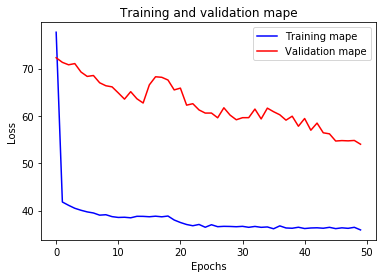

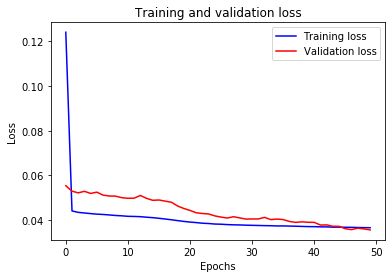

495927/495927 [==============================] - 4s 8us/sample - loss: 0.0463 - mape: 41.1538
test loss : [0.046290190147889036, 41.153793]


(0.05935244875955857, 0.04629019018419442)

In [429]:
model110, x_test110, y_test110, scaler110 = load_and_plot('retry_multi_step_1_10_3lstm_32', df, 1, 10)

prediction110 = model110.predict(x_test110)
np.mean(rmse(prediction110, y_test110)), np.mean(mae(prediction110, y_test110))

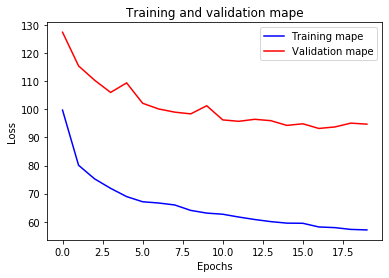

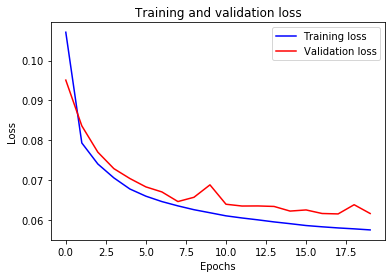

In [319]:
load_and_plot('multi_step_30_30_3lstm')

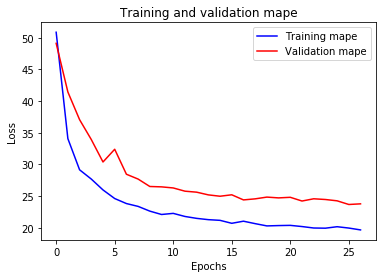

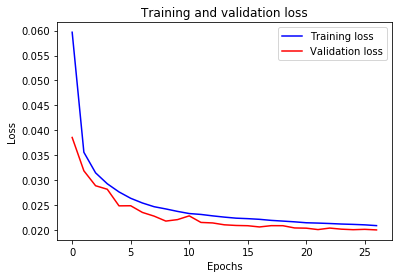

480736/480736 [==============================] - 37s 76us/sample - loss: 0.0240 - mape: 20.0567
test loss : [0.02398129184748019, 20.05669]


In [13]:
model = load_and_plot('retry_multi_step_30_10_3lstm_32')

In [14]:
prediction = model.predict(x_test)

In [15]:
samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [16]:
prediction.shape, y_test.shape

((480736, 10, 2), (480736, 10, 2))

In [43]:
show_traj(47400)

In [19]:
show_traj_recc(19905, 30, 10)

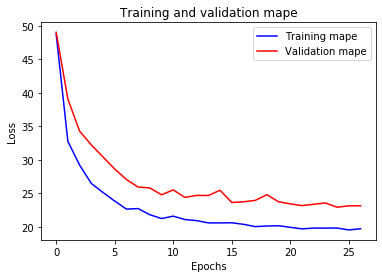

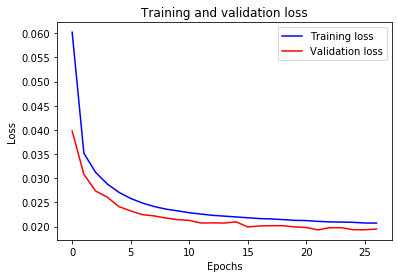

485952/485952 [==============================] - 26s 54us/sample - loss: 0.0234 - mape: 19.6873
test loss : [0.023430506900279396, 19.687346]


In [9]:
model = load_and_plot('retry_multi_step_20_10_3lstm_32')

In [10]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [11]:
show_traj(19915)

In [60]:
show_traj_recc(19915, 20, 10)

ValueError: cannot reshape array of size 2 into shape (10,2)

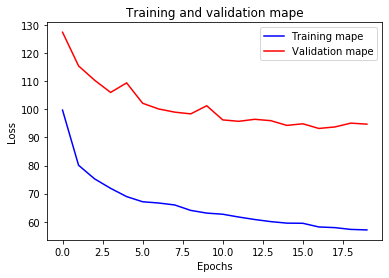

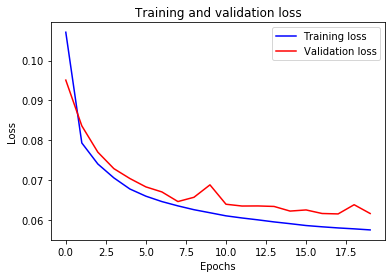

470674/470674 [==============================] - 36s 77us/sample - loss: 0.0750 - mape: 67.6510
test loss : [0.0749964642757579, 67.650986]


In [599]:
model = load_and_plot('multi_step_30_30_3lstm')

In [600]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [612]:
show_traj(2030)

In [613]:
show_traj(19905)

In [614]:
show_traj(19800)

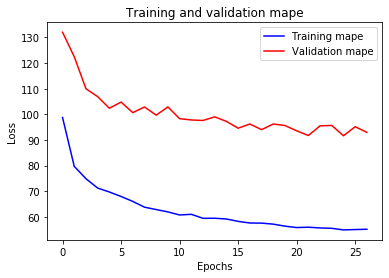

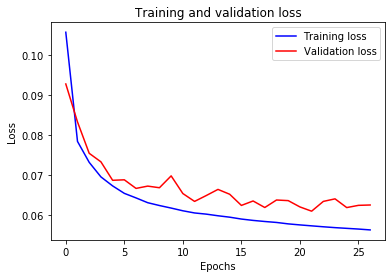

465871/465871 [==============================] - 47s 100us/sample - loss: 0.0759 - mape: 69.2851
test loss : [0.07592277208286298, 69.28507]


In [590]:
model = load_and_plot('retry30_multi_step_40_30_3lstm_32')

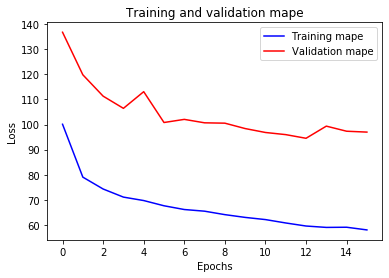

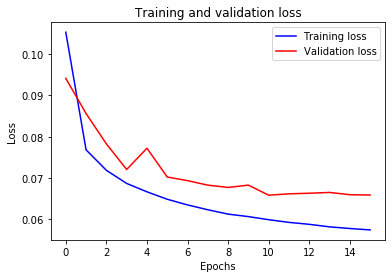

456715/456715 [==============================] - 68s 148us/sample - loss: 0.0792 - mape: 71.1885
test loss : [0.07920562829716876, 71.18848]


In [592]:
model = load_and_plot('retry30_multi_step_60_30_3lstm_32')

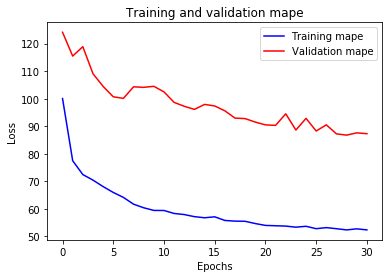

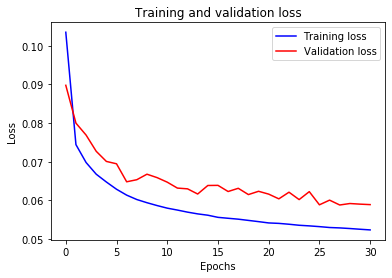

448218/448218 [==============================] - 78s 174us/sample - loss: 0.0713 - mape: 65.3839
test loss : [0.07129171330742527, 65.38389]


In [594]:
model = load_and_plot('retry30_multi_step_80_30_3lstm_32')

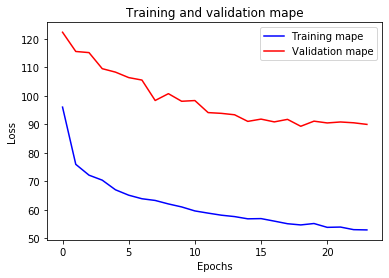

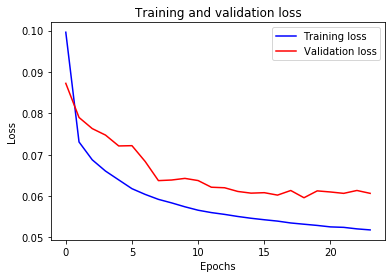

440311/440311 [==============================] - 99s 224us/sample - loss: 0.0730 - mape: 67.0496
test loss : [0.0729752507923264, 67.04961]


In [596]:
model = load_and_plot('retry30_multi_step_100_30_3lstm_32')

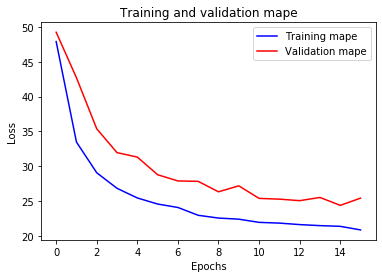

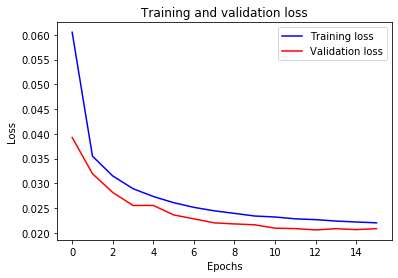

   256/485427 [..............................] - ETA: 5:20

ValueError: Dimensions must be equal, but are 20 and 2 for 'loss/dense_1_loss/sub' (op: 'Sub') with input shapes: [?,20], [?,1,2].

In [62]:
model, x_test, y_test, scaler = load_and_plot('multi_step_30_10_3lstm')

In [ ]:
model = load_and_plot('retr')

In [556]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [557]:
show_traj(19925)

In [582]:
show_traj_recc(19925, 10, 10)

ValueError: operands could not be broadcast together with shapes (180,) (2,) (180,) 

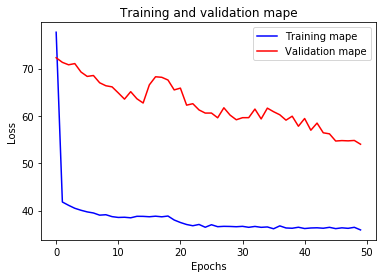

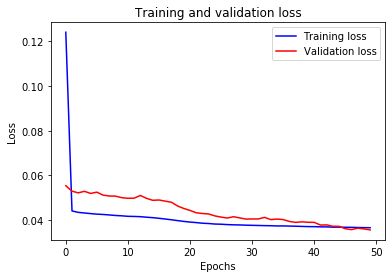

495927/495927 [==============================] - 4s 7us/sample - loss: 0.0463 - mape: 41.1538
test loss : [0.046290190147889036, 41.153793]


In [363]:
load_and_plot('retry_multi_step_1_10_3lstm_32')

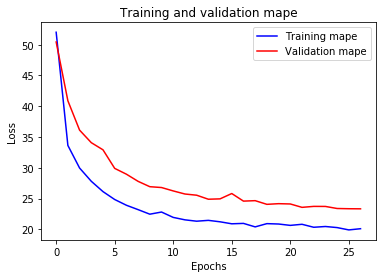

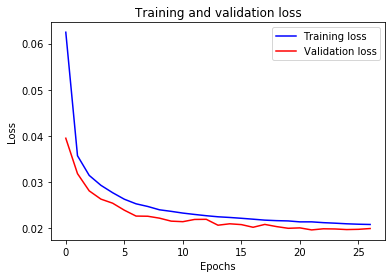

475645/475645 [==============================] - 49s 102us/sample - loss: 0.0238 - mape: 20.0455
test loss : [0.02383531584816386, 20.045475]


In [365]:
load_and_plot('retry_multi_step_40_10_3lstm_32')

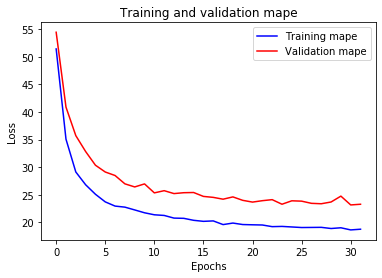

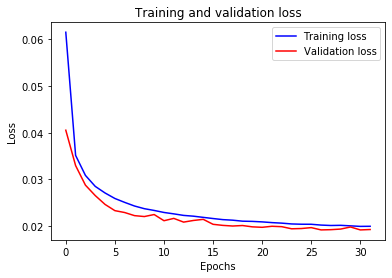

465871/465871 [==============================] - 63s 135us/sample - loss: 0.0229 - mape: 19.9757
test loss : [0.02289272992549269, 19.975716]


In [367]:
load_and_plot('retry_multi_step_60_10_3lstm_32')

In [37]:
prediction = model.predict(x_test)

In [72]:
prediction[0], y_test[0]

(array([0.9535373, 0.5244273], dtype=float32), array([0.95343443, 0.52715185]))

In [67]:
x_0 = inverse_to_df(x_test[0], scaler)

In [345]:
show_traj(2037)

In [212]:
prediction[2030:2030+1]
# inverse_to_df(prediction[2030:2030+1], scaler)

array([[0.62654054, 0.5384747 ]], dtype=float32)

In [352]:
show_traj_recc(42323)

### Linear interpolation MAE RMSE MAPE

In [98]:
df1 = pd.read_csv('final_dataset_ori_full_features.csv')
df1.drop(columns=['Unnamed: 0'], inplace=True)
print('finished reading {} records'.format(len(df1)))

finished reading 2508510 records


In [99]:
df1.head()

time       mmsi     speed     course  turn         lon  \
0  2019-12-01 00:22:00  205408000  4.848333  76.583333   0.0  103.538121   
1  2019-12-01 00:23:00  205408000  4.898333  74.083333   0.0  103.539436   
2  2019-12-01 00:24:00  205408000  4.760370  71.851852   0.0  103.540592   
3  2019-12-01 00:25:00  205408000  4.615926  69.629630   0.0  103.541742   
4  2019-12-01 00:26:00  205408000  4.471481  67.407407   0.0  103.542892   

        lat  id  
0  1.181544   1  
1  1.181869   1  
2  1.182298   1  
3  1.182730   1  
4  1.183162   1

In [84]:
df.head()

time       mmsi         lon       lat
0  2019-12-01 00:22:00  205408000  103.538121  1.181544
1  2019-12-01 00:23:00  205408000  103.539436  1.181869
2  2019-12-01 00:24:00  205408000  103.540592  1.182298
3  2019-12-01 00:25:00  205408000  103.541742  1.182730
4  2019-12-01 00:26:00  205408000  103.542892  1.183162

In [100]:
len(df), len(df1)

(2508510, 2508510)


X test shape: (448218, 80, 2), y test shape: (448218, 60) 


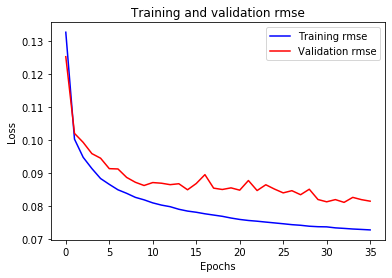

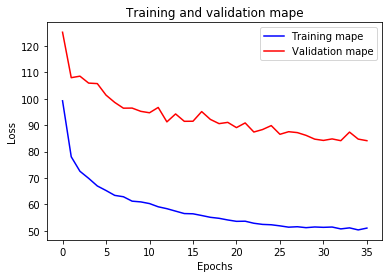

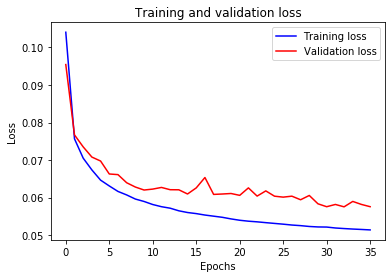

448218/448218 [==============================] - 79s 176us/sample - loss: 0.0697 - mae: 0.0697 - rmse: 0.0982 - mape: 63.9602
test loss : [0.06974507084477792, 0.06974507, 0.09818843, 63.960186]


In [146]:
model80, x_test80, y_test80, scaler80 = load_and_plot('linear_rmse_multi_step_30_80', 80, 30)

In [147]:
prediction80 = model80.predict(x_test80)

samples, size = prediction80.shape
prediction80 = prediction80.reshape(samples, size//2, 2)
y_test80 = y_test80.reshape(samples, size//2, 2)

In [149]:
show_traj(19800, x_test80, y_test80, prediction80, scaler80)

In [150]:
show_traj(19905, x_test80, y_test80, prediction80, scaler80)


X test shape: (456715, 60, 2), y test shape: (456715, 60) 


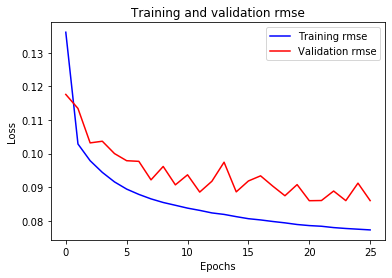

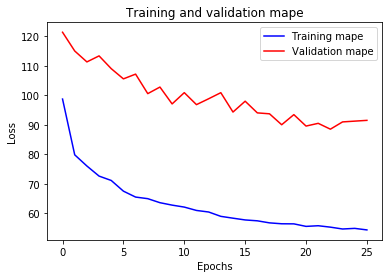

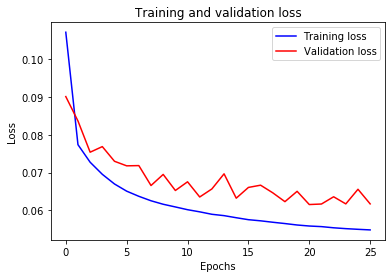

456715/456715 [==============================] - 64s 140us/sample - loss: 0.0746 - mae: 0.0746 - rmse: 0.1041 - mape: 68.4100
test loss : [0.07461262673154907, 0.0746127, 0.104105465, 68.409996]


In [109]:
model, x_test, y_test, scaler = load_and_plot('linear_rmse_multi_step_30_60', 60, 30)

In [102]:
prediction = model.predict(x_test)
rmse(prediction.reshape(-1,), y_test.reshape(-1,))

<tf.Tensor: shape=(), dtype=float64, numpy=0.18359902554021723>


X test shape: (465871, 40, 2), y test shape: (465871, 60) 


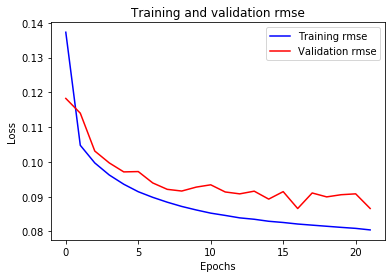

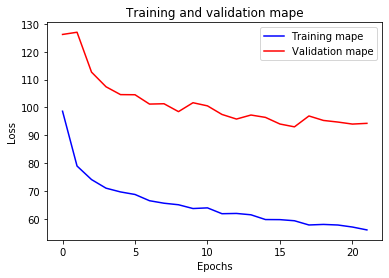

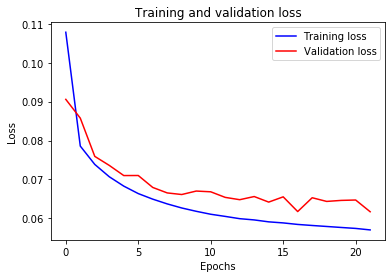

465871/465871 [==============================] - 49s 105us/sample - loss: 0.0745 - mae: 0.0745 - rmse: 0.1044 - mape: 67.7001
test loss : [0.07445088508400634, 0.07445082, 0.10440405, 67.70008]


In [128]:
model40, x_test40, y_test40, scaler40 = load_and_plot('linear_rmse_multi_step_30_40', 40, 30)

In [130]:
prediction40 = model40.predict(x_test40)

samples, size = prediction40.shape
prediction40 = prediction40.reshape(samples, size//2, 2)
y_test40 = y_test40.reshape(samples, size//2, 2)

In [132]:
show_traj(19905, x_test40, y_test40, prediction40, scaler40)

In [144]:
show_traj(19800, x_test40, y_test40, prediction40, scaler40)

In [165]:
show_traj(2021, x_test40, y_test40, prediction40, scaler40)


X test shape: (470674, 30, 2), y test shape: (470674, 60) 


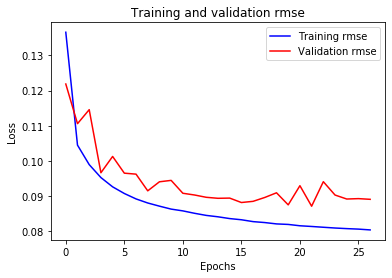

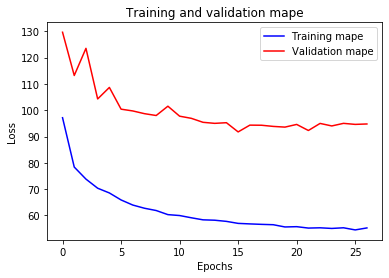

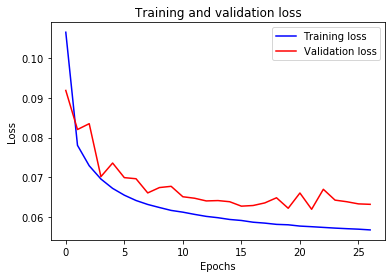

470674/470674 [==============================] - 36s 77us/sample - loss: 0.0763 - mae: 0.0763 - rmse: 0.1071 - mape: 67.9657
test loss : [0.07626681810550405, 0.076266795, 0.10706295, 67.9657]


In [145]:
model3030, x_test3030, y_test3030, scaler3030 = load_and_plot('linear_rmse_multi_step_30_30', df, 30, 30)

In [147]:
prediction3030 = model3030.predict(x_test3030, batch_size=256)

samples, size = prediction3030.shape
prediction3030 = prediction3030.reshape(samples, size//2, 2)
y_test3030 = y_test3030.reshape(samples, size//2, 2)

In [150]:
show_recursive_traj(19905, x_test3030, y_test3030, model3030, scaler3030, 30, 30)

In [125]:
prediction = model.predict(x_test)

samples, size = prediction.shape
prediction = prediction.reshape(samples, size//2, 2)
y_test = y_test.reshape(samples, size//2, 2)

In [126]:
show_traj(19905)

In [145]:
show_traj(19800, x_test, y_test, prediction, scaler)


X test shape: (475645, 20, 2), y test shape: (475645, 60) 


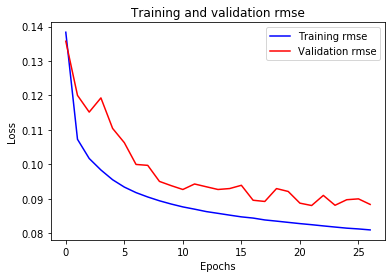

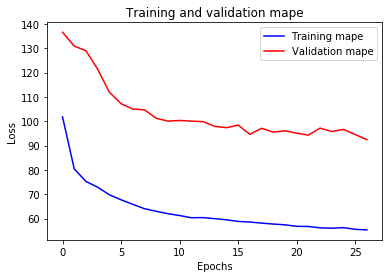

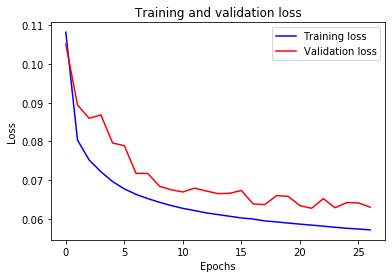

475645/475645 [==============================] - 25s 52us/sample - loss: 0.0772 - mae: 0.0772 - rmse: 0.1083 - mape: 68.8860
test loss : [0.07719049492258226, 0.07719053, 0.10825103, 68.88599]


In [112]:
model, x_test, y_test, scaler = load_and_plot('linear_rmse_multi_step_30_20', 20, 30)


X test shape: (480736, 10, 2), y test shape: (480736, 60) 


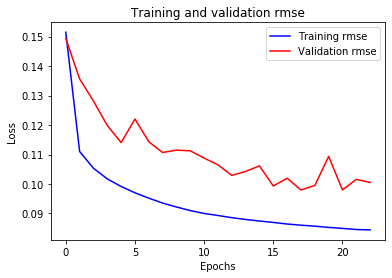

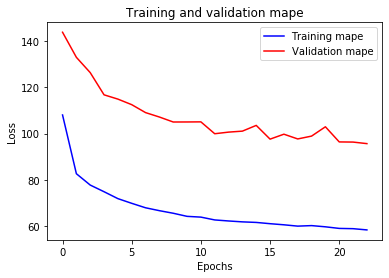

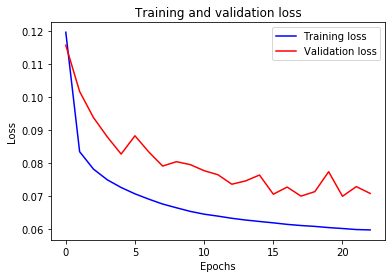

480736/480736 [==============================] - 14s 29us/sample - loss: 0.0840 - mae: 0.0840 - rmse: 0.1182 - mape: 71.7560
test loss : [0.08395380399571209, 0.08395387, 0.11820072, 71.75603]


In [113]:
model, x_test, y_test, scaler = load_and_plot('linear_rmse_multi_step_30_10', 10, 30)


X test shape: (485427, 1, 2), y test shape: (485427, 60) 


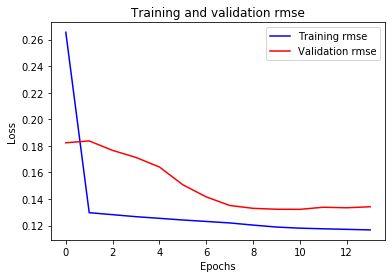

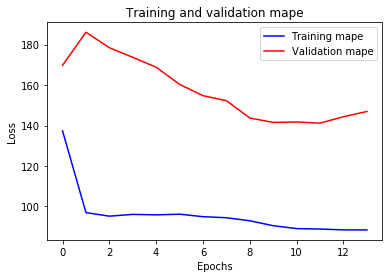

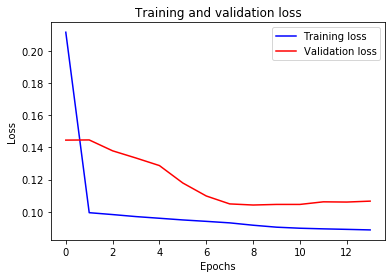

485427/485427 [==============================] - 4s 8us/sample - loss: 0.1426 - mae: 0.1426 - rmse: 0.1791 - mape: 114.2650
test loss : [0.1426443940062342, 0.14264442, 0.1790836, 114.26498]


In [114]:
model, x_test, y_test, scaler = load_and_plot('linear_rmse_multi_step_30_1', 1, 30)

### Spline

In [155]:
spline = pd.read_csv('final_dataset_spline.csv')
spline.drop(columns=['Unnamed: 0'], inplace=True)
print('finished reading {} records'.format(len(spline)))

finished reading 2508510 records


In [156]:
spline.head()

time       mmsi         lon       lat
0  2019-12-01 00:22:00  205408000  103.538453  1.181110
1  2019-12-01 00:23:00  205408000  103.540066  1.181498
2  2019-12-01 00:24:00  205408000  103.541561  1.181921
3  2019-12-01 00:25:00  205408000  103.542941  1.182378
4  2019-12-01 00:26:00  205408000  103.544213  1.182869

In [163]:
smodel301, sx_test301, sy_test301, sscaler301 = load_and_plot('spline_multi_step_1_30_3lstm_32', spline, 30, 1)


X test shape: (485427, 30, 2), y test shape: (485427, 2) 


In [168]:
sprediction301 = smodel301.predict(sx_test301, batch_size=256)
# np.mean(rmse(sprediction301, sy_test301)), np.mean(mae(sprediction301, sy_test301))
samples, size = sprediction301.shape
sprediction301 = sprediction301.reshape(samples, size//2, 2)
sy_test301 = sy_test301.reshape(samples, size//2, 2)

In [209]:
show_traj(2036, sx_test301, sy_test301, sprediction301, sscaler301)


X test shape: (490677, 20, 2), y test shape: (490677, 2) 


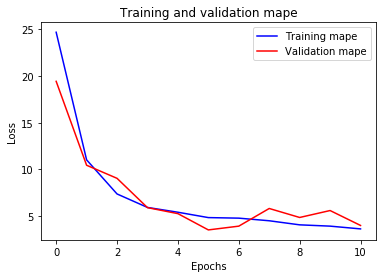

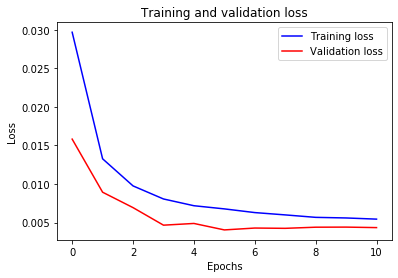

490677/490677 [==============================] - 27s 54us/sample - loss: 0.0054 - mape: 7.3435
test loss : [0.005365686923900582, 7.343526]


(0.0059533473699438086, 0.005365686910611207)

In [419]:
smodel201, sx_test201, sy_test201, sscaler201 = load_and_plot('spline_multi_step_1_20_3lstm_32', spline, 20, 1)

sprediction201 = smodel201.predict(sx_test201)
np.mean(rmse(sprediction201, sy_test201)), np.mean(mae(sprediction201, sy_test201))


X test shape: (495927, 10, 2), y test shape: (495927, 2) 


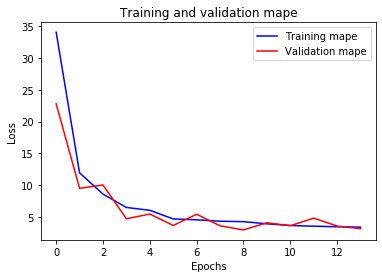

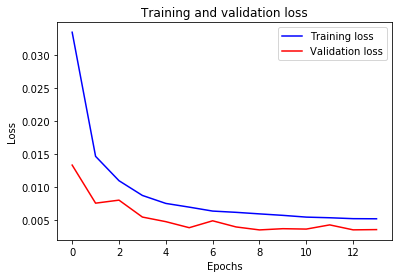

495927/495927 [==============================] - 15s 29us/sample - loss: 0.0043 - mape: 3.7138
test loss : [0.004309533568641269, 3.7137542]


(0.004843027534265615, 0.004309533618644136)

In [421]:
smodel101, sx_test101, sy_test101, sscaler101 = load_and_plot('spline_multi_step_1_10_3lstm_32', spline, 10, 1)

sprediction101 = smodel101.predict(sx_test101)
np.mean(rmse(sprediction101, sy_test101)), np.mean(mae(sprediction101, sy_test101))


X test shape: (500652, 1, 2), y test shape: (500652, 2) 


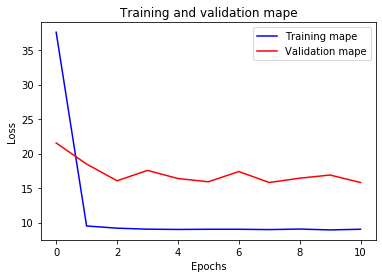

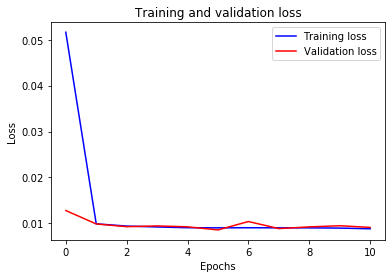

500652/500652 [==============================] - 4s 8us/sample - loss: 0.0115 - mape: 12.3292
test loss : [0.011513030003173903, 12.329219]


(0.012874035317168086, 0.011513030028628267)

In [422]:
smodel11, sx_test11, sy_test11, sscaler11 = load_and_plot('spline_multi_step_1_1_3lstm_32', spline, 1, 1)

sprediction11 = smodel11.predict(sx_test11)
np.mean(rmse(sprediction11, sy_test11)), np.mean(mae(sprediction11, sy_test11))


X test shape: (456715, 80, 2), y test shape: (456715, 20) 


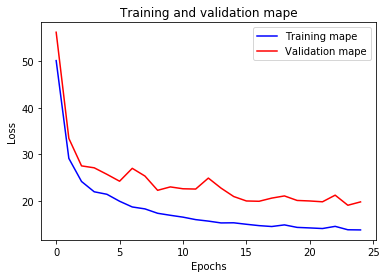

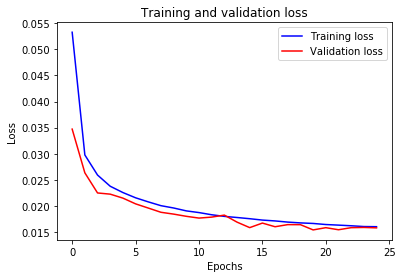

456715/456715 [==============================] - 89s 194us/sample - loss: 0.0196 - mape: 14.0292
test loss : [0.019562406459095856, 14.029232]


(0.02695056743753848, 0.019562406745982606)

In [431]:
smodel8010, sx_test8010, sy_test8010, sscaler8010 = load_and_plot('spline_multi_step_10_80_3lstm_32', spline, 80, 10)

sprediction8010 = smodel8010.predict(sx_test8010)
np.mean(rmse(sprediction8010, sy_test8010)), np.mean(mae(sprediction8010, sy_test8010))


X test shape: (465871, 60, 2), y test shape: (465871, 20) 


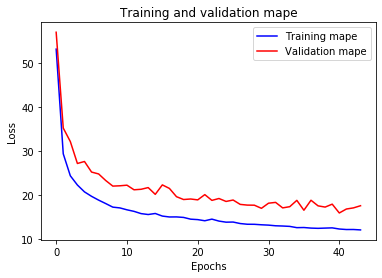

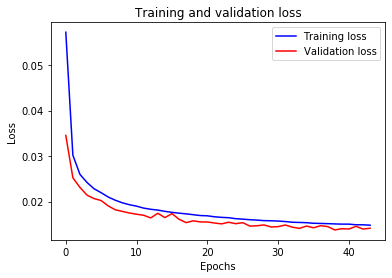

465871/465871 [==============================] - 66s 143us/sample - loss: 0.0173 - mape: 77.2217
test loss : [0.01729905181268134, 77.2217]


(0.024229738804346916, 0.0172990521277808)

In [432]:
smodel6010, sx_test6010, sy_test6010, sscaler6010 = load_and_plot('spline_multi_step_10_60_3lstm_32', spline, 60, 10)

sprediction6010 = smodel6010.predict(sx_test6010)
np.mean(rmse(sprediction6010, sy_test6010)), np.mean(mae(sprediction6010, sy_test6010))


X test shape: (475645, 40, 2), y test shape: (475645, 20) 


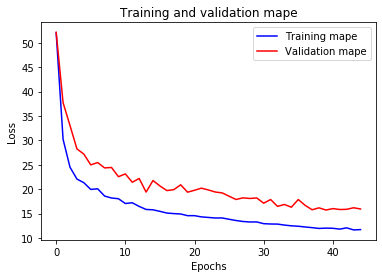

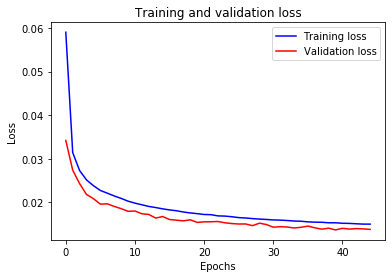

475645/475645 [==============================] - 53s 111us/sample - loss: 0.0173 - mape: 58.5953
test loss : [0.017305533780494094, 58.595306]


(0.024223494078883138, 0.017305533515474727)

In [433]:
smodel4010, sx_test4010, sy_test4010, sscaler4010 = load_and_plot('spline_multi_step_10_40_3lstm_32', spline, 40, 10)

sprediction4010 = smodel4010.predict(sx_test4010)
np.mean(rmse(sprediction4010, sy_test4010)), np.mean(mae(sprediction4010, sy_test4010))

In [186]:
smodel3010, sx_test3010, sy_test3010, sscaler3010 = load_and_plot('spline_multi_step_10_30_3lstm_32', spline, 30, 10)

sprediction3010 = smodel3010.predict(sx_test3010, batch_size=256)
samples, size = sprediction3010.shape
sprediction3010 = sprediction3010.reshape(samples, size//2, 2)
sy_test3010 = sy_test3010.reshape(samples, size//2, 2)
# np.mean(rmse(sprediction3010, sy_test3010)), np.mean(mae(sprediction3010, sy_test3010))


X test shape: (480736, 30, 2), y test shape: (480736, 20) 


In [187]:
samples, size = sprediction3010.shape
sprediction3010 = sprediction3010.reshape(samples, size//2, 2)
sy_test3010 = sy_test3010.reshape(samples, size//2, 2)

In [213]:
show_traj(19905, sx_test3010, sy_test3010, sprediction3010, sscaler3010)

In [190]:
smodel2010, sx_test2010, sy_test2010, sscaler2010 = load_and_plot('spline_multi_step_10_20_3lstm_32', spline, 20, 10)

sprediction2010 = smodel2010.predict(sx_test2010)
# np.mean(rmse(sprediction2010, sy_test2010)), np.mean(mae(sprediction2010, sy_test2010))
samples, size = sprediction2010.shape
sprediction2010 = sprediction2010.reshape(samples, size//2, 2)
sy_test2010 = sy_test2010.reshape(samples, size//2, 2)


X test shape: (485952, 20, 2), y test shape: (485952, 20) 


In [214]:
show_traj(19915, sx_test2010, sy_test2010, sprediction2010, sscaler2010)


X test shape: (491202, 10, 2), y test shape: (491202, 20) 


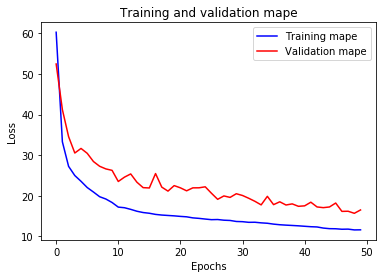

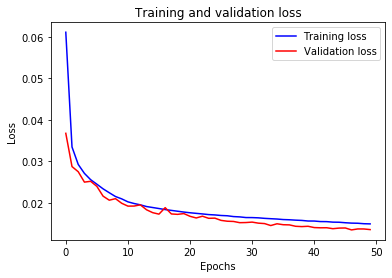

491202/491202 [==============================] - 16s 32us/sample - loss: 0.0170 - mape: 29.4649
test loss : [0.01698013825818101, 29.46488]


(0.02407456904334254, 0.01698013901850133)

In [436]:
smodel1010, sx_test1010, sy_test1010, sscaler1010 = load_and_plot('spline_multi_step_10_10_3lstm_32', spline, 10, 10)

sprediction1010 = smodel1010.predict(sx_test1010)
np.mean(rmse(sprediction1010, sy_test1010)), np.mean(mae(sprediction1010, sy_test1010))


X test shape: (495927, 1, 2), y test shape: (495927, 20) 


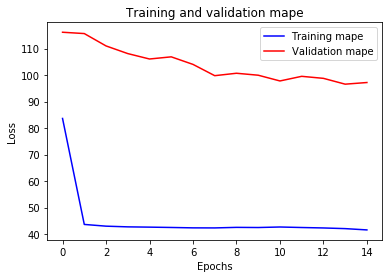

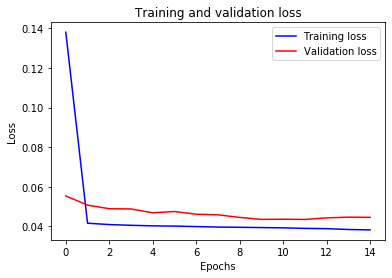

495927/495927 [==============================] - 4s 8us/sample - loss: 0.0590 - mape: 70.4758
test loss : [0.059035068598454386, 70.47578]


(0.07439246344030206, 0.05903506851811225)

In [438]:
smodel101, sx_test101, sy_test101, sscaler101 = load_and_plot('spline_multi_step_10_1_3lstm_32', spline, 1, 10)

sprediction101 = smodel101.predict(sx_test101)
np.mean(rmse(sprediction101, sy_test101)), np.mean(mae(sprediction101, sy_test101))


X test shape: (485427, 1, 2), y test shape: (485427, 60) 


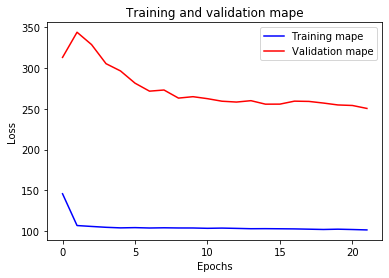

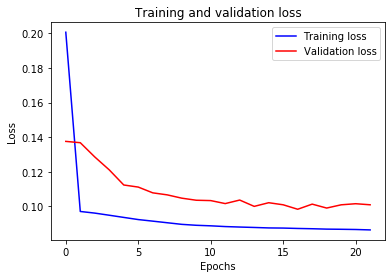

485427/485427 [==============================] - 4s 8us/sample - loss: 0.1347 - mape: 108.9710
test loss : [0.13465977056985134, 108.97102]


In [159]:
smodel1, sx_test1, sy_test1, sscaler1 = load_and_plot('spline_multi_step_30_1_3lstm_32', 1, 30)

In [167]:
sprediction1 = smodel1.predict(sx_test1)

# samples, size = sprediction1.shape
# sprediction1 = sprediction1.reshape(samples, size//2, 2)
# sy_test1 = sy_test1.reshape(samples, size//2, 2)

In [176]:
np.mean(rmse(sprediction1, sy_test1.reshape(-1,60)))

0.17019787108891565


X test shape: (480736, 10, 2), y test shape: (480736, 60) 


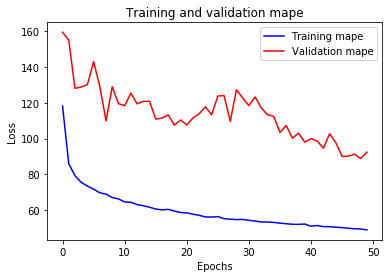

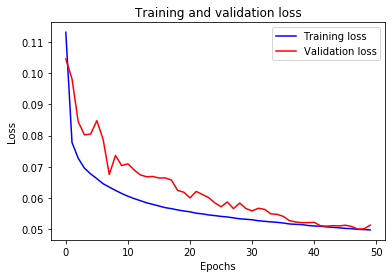

480736/480736 [==============================] - 15s 31us/sample - loss: 0.0803 - mape: 73.0905
test loss : [0.08033889492612017, 73.0905]


In [177]:
smodel10, sx_test10, sy_test10, sscaler10 = load_and_plot('spline_multi_step_30_10_3lstm_32', 10, 30)

In [179]:
sprediction10 = smodel10.predict(sx_test10)
np.mean(rmse(sprediction10, sy_test10))

0.11258845060683899


X test shape: (475645, 20, 2), y test shape: (475645, 60) 


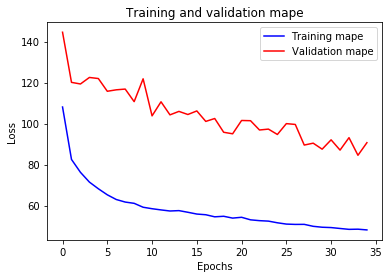

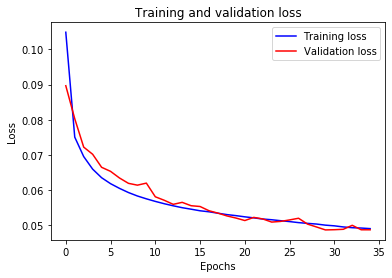

475645/475645 [==============================] - 27s 56us/sample - loss: 0.0784 - mape: 72.3085
test loss : [0.07839542216773761, 72.30849]


In [180]:
smodel20, sx_test20, sy_test20, sscaler20 = load_and_plot('spline_multi_step_30_20_3lstm_32', 20, 30)

In [181]:
sprediction20 = smodel20.predict(sx_test20)
np.mean(rmse(sprediction20, sy_test20))

0.10984996992045018

In [183]:
np.mean(mae(sprediction20, sy_test20))

0.07839542185633996

In [194]:
smodel3030, sx_test3030, sy_test3030, sscaler3030 = load_and_plot('spline_multi_step_30_30_3lstm_32', spline, 30, 30)

sprediction3030 = smodel3030.predict(sx_test3030, batch_size=256)
samples, size = sprediction3030.shape
sprediction3030 = sprediction3030.reshape(samples, size//2, 2)
sy_test3030 = sy_test3030.reshape(samples, size//2, 2)


X test shape: (470674, 30, 2), y test shape: (470674, 60) 


In [216]:
show_traj(19925, sx_test3030, sy_test3030, sprediction3030, sscaler3030)

In [184]:
sprediction30 = smodel30.predict(sx_test30)
np.mean(rmse(sprediction30, sy_test30))

0.10799896660421075

In [220]:
smodel40, sx_test40, sy_test40, sscaler40 = load_and_plot('spline_multi_step_30_40_3lstm_32',spline, 40, 30)

sprediction40 = smodel40.predict(sx_test40, batch_size=256)
samples, size = sprediction40.shape
sprediction40 = sprediction40.reshape(samples, size//2, 2)
sy_test40 = sy_test40.reshape(samples, size//2, 2)


X test shape: (465871, 40, 2), y test shape: (465871, 60) 


In [221]:
show_traj(19925, sx_test40, sy_test40, sprediction40, sscaler40)

In [244]:
sprediction40.shape

(465871, 60)

In [186]:
sprediction40 = smodel40.predict(sx_test40)
np.mean(rmse(sprediction40, sy_test40))

0.1080733986961233


X test shape: (456715, 60, 2), y test shape: (456715, 60) 


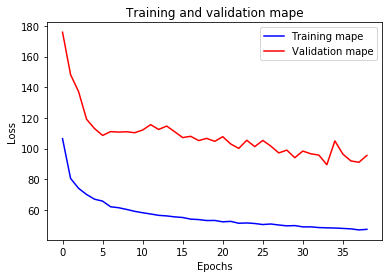

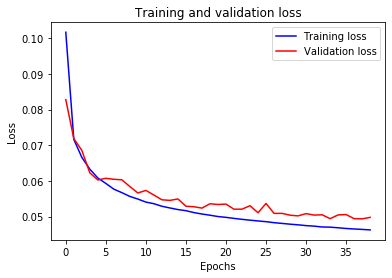

456715/456715 [==============================] - 67s 146us/sample - loss: 0.0782 - mape: 73.6177
test loss : [0.07821013409043909, 73.61769]


In [187]:
smodel60, sx_test60, sy_test60, sscaler60 = load_and_plot('spline_multi_step_30_60_3lstm_32', 60, 30)

In [188]:
sprediction60 = smodel60.predict(sx_test60)
np.mean(rmse(sprediction60, sy_test60))

0.10986098030615087


X test shape: (448218, 80, 2), y test shape: (448218, 60) 


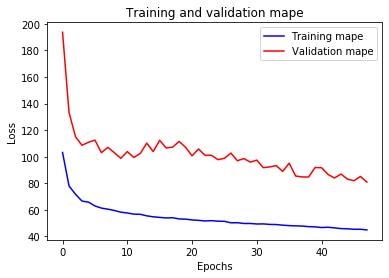

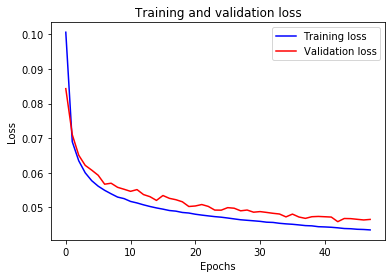

448218/448218 [==============================] - 86s 192us/sample - loss: 0.0752 - mape: 70.2998
test loss : [0.07517547746911356, 70.29981]


In [189]:
smodel80, sx_test80, sy_test80, sscaler80 = load_and_plot('spline_multi_step_30_80_3lstm_32', 80, 30)

In [190]:
sprediction80 = smodel80.predict(sx_test80)
np.mean(rmse(sprediction80, sy_test80))

0.10535055607257597

Recursive multi-step prediction

In [179]:
from random import sample
idx_list = sample(list(np.arange(470674)), 100)

In [178]:
idx_list

[219092,
 383360,
 419321,
 263845,
 282323,
 207686,
 155501,
 81804,
 73559,
 113150,
 446955,
 84880,
 184772,
 463718,
 321261,
 279501,
 70383,
 209870,
 142425,
 314696,
 296355,
 467765,
 82115,
 276838,
 49889,
 470629,
 434628,
 115045,
 10754,
 279175,
 187719,
 245993,
 380083,
 160290,
 406194,
 67550,
 169578,
 307304,
 439860,
 24275,
 345961,
 240428,
 455564,
 439361,
 400903,
 312839,
 69577,
 462851,
 445179,
 370430,
 144586,
 117142,
 380528,
 195923,
 430942,
 207729,
 227435,
 405648,
 20160,
 25636,
 48001,
 396410,
 134419,
 326353,
 264506,
 20466,
 150581,
 18689,
 312954,
 460570,
 12053,
 369241,
 162929,
 213483,
 335621,
 62798,
 324664,
 317394,
 206108,
 384766,
 321636,
 199850,
 55722,
 301907,
 294384,
 80314,
 190398,
 404140,
 98149,
 50384,
 198333,
 104629,
 192029,
 258678,
 216724,
 405170,
 400020,
 344186,
 148172,
 194467,
 10922,
 32831,
 180402,
 350495,
 264150,
 161571,
 325512,
 160157,
 158964,
 313061,
 143702,
 368844,
 26373,
 281451

In [184]:
def recursive_prediction(x, model, idx, lookback, target):
    steps, feats = x.shape[-2:]
    inp = x[idx].reshape(1, steps, feats)
    preds = []

    end_index = 30//target

    for i in range(0, end_index):
        inp = inp.reshape(1,steps,feats)
        pred = model.predict(inp).reshape(target, 2)
        preds.extend(pred.tolist())
        inp = inp.reshape(steps,feats).tolist()
        if i == end_index-1:
            break
        if ((i+1)*target >= lookback):
#             inp = np.array(preds)
#             print(len(preds), i+1)
#             print(len(preds[(i+1)*target-lookback:]))
            inp = np.array(preds[(i+1)*target-lookback:])
        else:
            inp = np.append(inp[(i+1)*target:lookback], preds, axis=0)
    return preds

def generate_targets(y, idx, lookback, target):
    targets = []
    end_index = 30//target

    for i in range(1, end_index+1):
        temp = y[idx+(i-1)*target]
        targets.extend(temp)
    return targets

def show_recursive_traj(idx, x, y, model, scaler, lookback, target):
    rec_y = generate_targets(y, idx, lookback, target)
    rec_pred = recursive_prediction(x, model, idx, lookback, target)
    return plot_predict(inverse_to_df(rec_y, scaler), 
                        inverse_to_df(rec_pred, scaler), 
                        inverse_to_df(x[idx], scaler))

def recursive_metrics(idx, x, y, model, scaler, lookback, target):
#     all_y = []
#     all_pred = []
#     for idx in range(x.shape[0]):
#         rec_y = generate_targets(y, idx, lookback, target)
#         rec_pred = recursive_prediction(x, model, idx, lookback, target)
# #         print(np.array(rec_y).reshape(1,-1))
# #         mae_score = mae(rec_pred, rec_y)
# #         rmse_score = rmse(rec_pred, rec_y)
#         all_y.append(np.array(rec_y).reshape(1,-1))
#         all_pred.append(np.array(rec_pred).reshape(1,-1))
#         break
    rec_y = generate_targets(y, idx, lookback, target)
    rec_pred = recursive_prediction(x, model, idx, lookback, target)
    rec_y = np.array(rec_y).reshape(-1,)
    rec_pred = np.array(rec_pred).reshape(-1,)    
    print('rmse:', rmse(rec_pred, rec_y))
    print('mae:', mae(rec_pred, rec_y))
    print('mape:', mape(rec_pred, rec_y))
    
def recursive_metrics_all(idx_list, x, y, model, scaler, lookback, target):
    mae_scores = []
    rmse_scores = []
    mape_scores = []
    print(x.shape, y.shape, lookback, target)
    # for idx in range(x.shape[0]-(2*target)-1):
    for idx in idx_list:
        rec_y = generate_targets(y, idx, lookback, target)
        rec_pred = recursive_prediction(x, model, idx, lookback, target)
        rec_y = np.array(rec_y).reshape(-1,)
        rec_pred = np.array(rec_pred).reshape(-1,)
        mae_score = mae(rec_pred, rec_y)
        rmse_score = rmse(rec_pred, rec_y)
        mape_score = mape(rec_pred, rec_y)
        mae_scores.append(mae_score.numpy())
        rmse_scores.append(rmse_score.numpy())
        mape_scores.append(mape_score.numpy())
        # print('{} : mae {}, rmse {} mape {}'.format(idx, mae_score, rmse_score, mape_score))
    print('index : {}\n'.format(idx))
    print(np.mean(mae_scores), np.mean(rmse_scores), np.mean(mape_scores))
    return np.mean(mae_scores), np.mean(rmse_scores), np.mean(mape_scores)

lookback = 30


X test shape: (470674, 30, 2), y test shape: (470674, 60) 


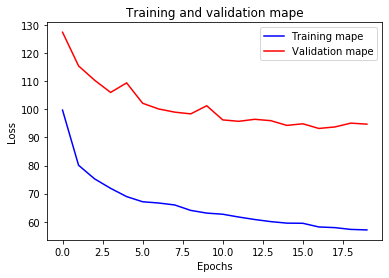

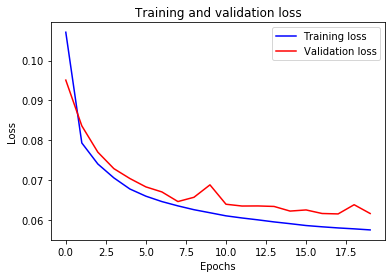

470674/470674 [==============================] - 39s 82us/sample - loss: 0.0750 - mape: 67.6510
test loss : [0.0749964642757579, 67.650986]


In [121]:
model3030, x_test3030, y_test3030, scaler3030 = load_and_plot('multi_step_30_30_3lstm', df, 30, 30)

prediction3030 = model3030.predict(x_test3030, batch_size=256)
samples, size = prediction3030.shape
prediction3030 = prediction3030.reshape(samples, size//2, 2)
y_test3030 = y_test3030.reshape(samples, size//2, 2)

In [122]:
show_recursive_traj(19905, x_test3030, y_test3030, model3030, scaler3030, 30, 30)

In [385]:
recursive_metrics(19905, x_test3030, y_test3030, model3030, scaler3030, 30, 30)

rmse: tf.Tensor(0.606130936833843, shape=(), dtype=float64)
mae: tf.Tensor(0.42306597838683285, shape=(), dtype=float64)
mape: tf.Tensor(1208.8144105812387, shape=(), dtype=float64)


In [170]:
model3010, x_test3010, y_test3010, scaler3010 = load_and_plot('retry_multi_step_30_10_3lstm_32', df, 30, 10)


X test shape: (480736, 30, 2), y test shape: (480736, 20) 


In [172]:
prediction3010 = model3010.predict(x_test3010, batch_size=256)

samples, size = prediction3010.shape
prediction3010 = prediction3010.reshape(samples, size//2, 2)
y_test3010 = y_test3010.reshape(samples, size//2, 2)

In [173]:
prediction3010.shape, y_test3010.shape

((480736, 10, 2), (480736, 10, 2))

In [354]:
show_recursive_traj(19905, x_test3010, y_test3010, model3010, scaler3010, 30, 10)

(1, 30, 2)


In [175]:
recursive_metrics(19905, x_test3010, y_test3010, model3010, scaler3010, 30, 10)

rmse: tf.Tensor(0.12344461588208407, shape=(), dtype=float64)
mae: tf.Tensor(0.09587806334649845, shape=(), dtype=float64)
mape: tf.Tensor(24.241912514012355, shape=(), dtype=float64)


In [185]:
recursive_metrics_all(idx_list, x_test3010, y_test3010, model3010, scaler3010, 30, 10)

(480736, 30, 2) (480736, 10, 2) 30 10
index : 183262

0.09898222642158769 0.14569999899315914 47.75836970946517


(0.09898222642158769, 0.14569999899315914, 47.75836970946517)


X test shape: (485427, 30, 2), y test shape: (485427, 2) 


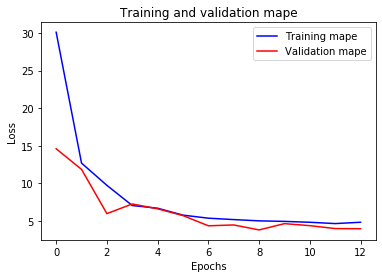

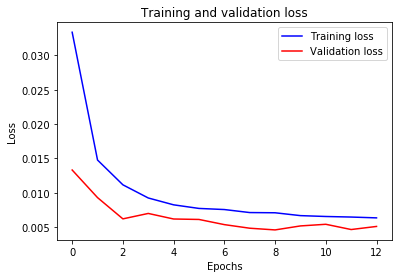

485427/485427 [==============================] - 38s 78us/sample - loss: 0.0057 - mape: 3.9145
test loss : [0.0057333800285480204, 3.914477]


In [272]:
model301, x_test301, y_test301, scaler301 = load_and_plot('retry_multi_step_30_1_3lstm_32', 30, 1)

In [273]:
prediction301 = model301.predict(x_test301)

samples, size = prediction301.shape
prediction301 = prediction301.reshape(samples, size//2, 2)
y_test301 = y_test301.reshape(samples, size//2, 2)

In [321]:
prediction301.shape, y_test301.shape

((485427, 1, 2), (485427, 1, 2))

In [355]:
show_recursive_traj(19905, x_test301, y_test301, model301, scaler301, 30, 1)

(1, 30, 2)


In [387]:
recursive_metrics(19905, x_test301, y_test301, model301, scaler301, 30, 1)

rmse: tf.Tensor(0.33326471250874523, shape=(), dtype=float64)
mae: tf.Tensor(0.2021660995827239, shape=(), dtype=float64)
mape: tf.Tensor(151.64964137967317, shape=(), dtype=float64)


lookback = 20


X test shape: (475645, 20, 2), y test shape: (475645, 60) 


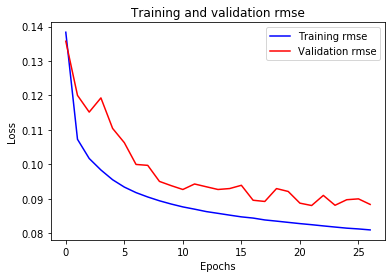

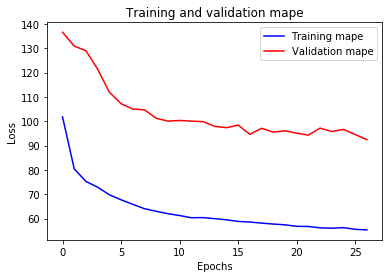

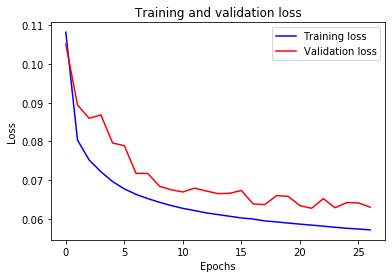

475645/475645 [==============================] - 26s 55us/sample - loss: 0.0772 - mae: 0.0772 - rmse: 0.1083 - mape: 68.8860
test loss : [0.07719049492258226, 0.07719053, 0.10825103, 68.88599]


In [394]:
model2030, x_test2030, y_test2030, scaler2030 = load_and_plot('linear_rmse_multi_step_30_20', 20, 30)

prediction2030 = model2030.predict(x_test2030)
samples, size = prediction2030.shape
prediction2010 = prediction2030.reshape(samples, size//2, 2)
y_test2030 = y_test2030.reshape(samples, size//2, 2)

In [397]:
show_recursive_traj(19915, x_test2030, y_test2030, model2030, scaler2030, 20, 30)

In [398]:
recursive_metrics(19915, x_test2030, y_test2030, model2030, scaler2030, 20, 30)

rmse: tf.Tensor(0.6234397984026052, shape=(), dtype=float64)
mae: tf.Tensor(0.44886673173415575, shape=(), dtype=float64)
mape: tf.Tensor(526.6375591567462, shape=(), dtype=float64)



X test shape: (485952, 20, 2), y test shape: (485952, 20) 


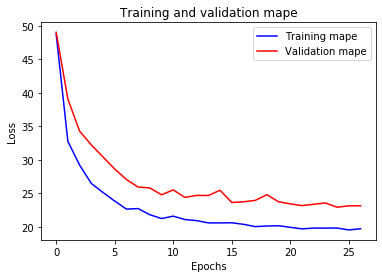

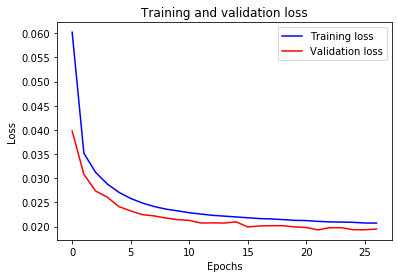

485952/485952 [==============================] - 26s 53us/sample - loss: 0.0234 - mape: 19.6873
test loss : [0.023430506900279396, 19.687346]
(485952, 20) (485952, 20)


In [59]:
model2010, x_test2010, y_test2010, scaler2010 = load_and_plot('retry_multi_step_20_10_3lstm_32', df, 20, 10)



prediction2010 = model2010.predict(x_test2010, batch_size=256)
print(prediction2010.shape, y_test2010.shape)
# samples, size = prediction2010.shape
# prediction2010 = prediction2010.reshape(samples, size//2, 2)
# y_test2010 = y_test2010.reshape(samples, size//2, 2)

In [77]:
x_test = x_test2010[0:240, :, :]
y_test = y_test2010[0:240,:]
prediction = model2010.predict(x_test, batch_size=240)

# print(prediction2010.shape, y_test2010.shape)
x_test.shape, prediction.shape, y_test.shape

((240, 20, 2), (240, 20), (240, 20))

In [78]:
y_test

array([[0.95298429, 0.52142582, 0.95318169, ..., 0.52477799, 0.95360561,
        0.52596492],
       [0.95318169, 0.52252843, 0.9533791 , ..., 0.52596492, 0.95343443,
        0.52715185],
       [0.9533791 , 0.52363104, 0.9535765 , ..., 0.52715185, 0.95326324,
        0.52833878],
       ...,
       [0.54720407, 0.81479588, 0.53508393, ..., 0.57952236, 0.71120968,
        0.54651953],
       [0.53508393, 0.80095912, 0.54116959, ..., 0.54651953, 0.73618803,
        0.51687462],
       [0.54116959, 0.77753932, 0.56546103, ..., 0.51687462, 0.76422627,
        0.50218772]])

In [81]:
y_new = y_test.reshape(-1,60)

In [84]:
y_new[0], y_new[0]

(array([0.95298429, 0.52142582, 0.95318169, 0.52252843, 0.9533791 ,
        0.52363104, 0.9535765 , 0.52473365, 0.95374943, 0.52560759,
        0.95378366, 0.52518568, 0.95381788, 0.52476376, 0.95385211,
        0.52434185, 0.95377679, 0.52477799, 0.95360561, 0.52596492,
        0.95318169, 0.52252843, 0.9533791 , 0.52363104, 0.9535765 ,
        0.52473365, 0.95374943, 0.52560759, 0.95378366, 0.52518568,
        0.95381788, 0.52476376, 0.95385211, 0.52434185, 0.95377679,
        0.52477799, 0.95360561, 0.52596492, 0.95343443, 0.52715185,
        0.9533791 , 0.52363104, 0.9535765 , 0.52473365, 0.95374943,
        0.52560759, 0.95378366, 0.52518568, 0.95381788, 0.52476376,
        0.95385211, 0.52434185, 0.95377679, 0.52477799, 0.95360561,
        0.52596492, 0.95343443, 0.52715185, 0.95326324, 0.52833878]),
 60)

In [89]:
np.array(targets)

array([0.95298429, 0.52142582, 0.95318169, 0.52252843, 0.9533791 ,
       0.52363104, 0.9535765 , 0.52473365, 0.95374943, 0.52560759,
       0.95378366, 0.52518568, 0.95381788, 0.52476376, 0.95385211,
       0.52434185, 0.95377679, 0.52477799, 0.95360561, 0.52596492,
       0.95343443, 0.52715185, 0.95326324, 0.52833878, 0.95309206,
       0.52952571, 0.95292088, 0.53071264, 0.9527497 , 0.53189957,
       0.95257852, 0.5330865 , 0.95240734, 0.53427342, 0.95223616,
       0.53546035, 0.95206498, 0.53664728, 0.9518938 , 0.53783421,
       0.95172262, 0.53902114, 0.95168399, 0.53952686, 0.95176936,
       0.53939532, 0.95185473, 0.53926377, 0.9519401 , 0.53913223,
       0.95203188, 0.5390544 , 0.95215567, 0.53924514, 0.95224851,
       0.53938819, 0.95218662, 0.53929282, 0.95149976, 0.53942975])

In [118]:
targets = []
target = 10
lookback = 20
end_index = 30//target
idx = 0

for i in range(1, end_index+1):
    temp = y_test[idx+(i-1)*target]
#     if (targets == []):
#         targets = temp
#     else:
#         targets = np.append(targets, temp, )
    targets.extend(temp)
len(targets)

60

In [115]:
indices = range(0,21,10)

In [116]:
indices

range(0, 21, 10)

In [117]:
y_test[indices].reshape(-1,)

array([0.95298429, 0.52142582, 0.95318169, 0.52252843, 0.9533791 ,
       0.52363104, 0.9535765 , 0.52473365, 0.95374943, 0.52560759,
       0.95378366, 0.52518568, 0.95381788, 0.52476376, 0.95385211,
       0.52434185, 0.95377679, 0.52477799, 0.95360561, 0.52596492,
       0.95343443, 0.52715185, 0.95326324, 0.52833878, 0.95309206,
       0.52952571, 0.95292088, 0.53071264, 0.9527497 , 0.53189957,
       0.95257852, 0.5330865 , 0.95240734, 0.53427342, 0.95223616,
       0.53546035, 0.95206498, 0.53664728, 0.9518938 , 0.53783421,
       0.95172262, 0.53902114, 0.95168399, 0.53952686, 0.95176936,
       0.53939532, 0.95185473, 0.53926377, 0.9519401 , 0.53913223,
       0.95203188, 0.5390544 , 0.95215567, 0.53924514, 0.95224851,
       0.53938819, 0.95218662, 0.53929282, 0.95149976, 0.53942975])

In [119]:
np.array(targets)

array([0.95298429, 0.52142582, 0.95318169, 0.52252843, 0.9533791 ,
       0.52363104, 0.9535765 , 0.52473365, 0.95374943, 0.52560759,
       0.95378366, 0.52518568, 0.95381788, 0.52476376, 0.95385211,
       0.52434185, 0.95377679, 0.52477799, 0.95360561, 0.52596492,
       0.95343443, 0.52715185, 0.95326324, 0.52833878, 0.95309206,
       0.52952571, 0.95292088, 0.53071264, 0.9527497 , 0.53189957,
       0.95257852, 0.5330865 , 0.95240734, 0.53427342, 0.95223616,
       0.53546035, 0.95206498, 0.53664728, 0.9518938 , 0.53783421,
       0.95172262, 0.53902114, 0.95168399, 0.53952686, 0.95176936,
       0.53939532, 0.95185473, 0.53926377, 0.9519401 , 0.53913223,
       0.95203188, 0.5390544 , 0.95215567, 0.53924514, 0.95224851,
       0.53938819, 0.95218662, 0.53929282, 0.95149976, 0.53942975])

In [92]:
y_test[0]

array([0.95298429, 0.52142582, 0.95318169, 0.52252843, 0.9533791 ,
       0.52363104, 0.9535765 , 0.52473365, 0.95374943, 0.52560759,
       0.95378366, 0.52518568, 0.95381788, 0.52476376, 0.95385211,
       0.52434185, 0.95377679, 0.52477799, 0.95360561, 0.52596492])

In [94]:
y_test[1]

array([0.95318169, 0.52252843, 0.9533791 , 0.52363104, 0.9535765 ,
       0.52473365, 0.95374943, 0.52560759, 0.95378366, 0.52518568,
       0.95381788, 0.52476376, 0.95385211, 0.52434185, 0.95377679,
       0.52477799, 0.95360561, 0.52596492, 0.95343443, 0.52715185])

In [93]:
y_test[10]

array([0.95343443, 0.52715185, 0.95326324, 0.52833878, 0.95309206,
       0.52952571, 0.95292088, 0.53071264, 0.9527497 , 0.53189957,
       0.95257852, 0.5330865 , 0.95240734, 0.53427342, 0.95223616,
       0.53546035, 0.95206498, 0.53664728, 0.9518938 , 0.53783421])

In [51]:
show_recursive_traj(19915, x_test2010, y_test2010, model2010, scaler2010, 20, 10)

In [55]:
recursive_metrics(19915, x_test2010, y_test2010, model2010, scaler2010, 20, 10)

rmse: tf.Tensor(0.08335885833946712, shape=(), dtype=float64)
mae: tf.Tensor(0.06286872377243875, shape=(), dtype=float64)
mape: tf.Tensor(11.810250767489086, shape=(), dtype=float64)



X test shape: (490677, 20, 2), y test shape: (490677, 2) 


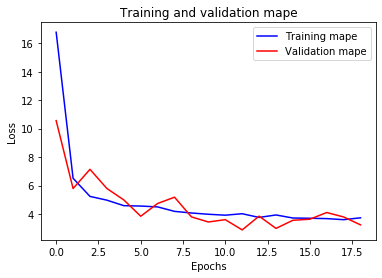

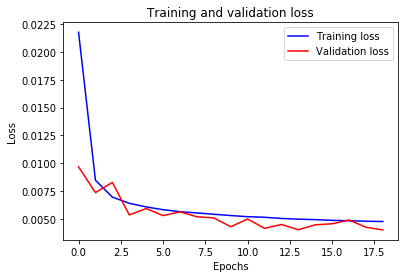

490677/490677 [==============================] - 26s 53us/sample - loss: 0.0047 - mape: 3.5691
test loss : [0.004709294091817678, 3.569136]


In [314]:
model201, x_test201, y_test201, scaler201 = load_and_plot('single_step_20_1_3lstm', 20, 1)

prediction201 = model201.predict(x_test201)
samples, size = prediction201.shape
prediction201 = prediction201.reshape(samples, size//2, 2)
y_test201 = y_test201.reshape(samples, size//2, 2)

In [357]:
show_recursive_traj(19915, x_test201, y_test201, model201, scaler201, 20, 1)

(1, 20, 2)


In [389]:
recursive_metrics(19915, x_test201, y_test201, model201, scaler201, 20, 1)

rmse: tf.Tensor(0.0820025495292151, shape=(), dtype=float64)
mae: tf.Tensor(0.06190616652848715, shape=(), dtype=float64)
mape: tf.Tensor(68.33615899288489, shape=(), dtype=float64)



X test shape: (491202, 10, 2), y test shape: (491202, 20) 


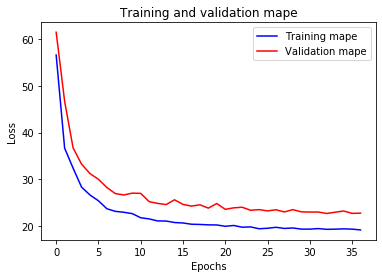

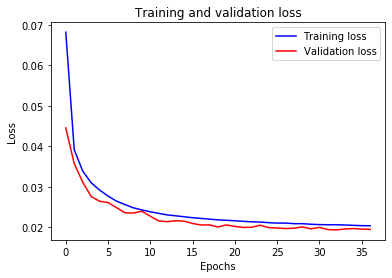

491202/491202 [==============================] - 16s 32us/sample - loss: 0.0233 - mape: 19.1035
test loss : [0.023283770621175807, 19.103529]


NameError: name 'prediction101' is not defined

In [358]:
model1010, x_test1010, y_test1010, scaler1010 = load_and_plot('retry_multi_step_10_10_3lstm_32', 10, 10)

prediction1010 = model1010.predict(x_test1010)
samples, size = prediction1010.shape

In [359]:
prediction1010 = prediction1010.reshape(samples, size//2, 2)
y_test1010 = y_test1010.reshape(samples, size//2, 2)

In [360]:
show_recursive_traj(19925, x_test1010, y_test1010, model1010, scaler1010, 10, 10)

(1, 10, 2)


In [390]:
recursive_metrics(19925, x_test1010, y_test1010, model1010, scaler1010, 10, 10)

rmse: tf.Tensor(0.11422316973054031, shape=(), dtype=float64)
mae: tf.Tensor(0.08779270602176341, shape=(), dtype=float64)
mape: tf.Tensor(17.237802432399736, shape=(), dtype=float64)



X test shape: (495927, 10, 2), y test shape: (495927, 2) 


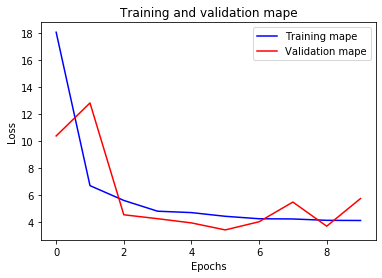

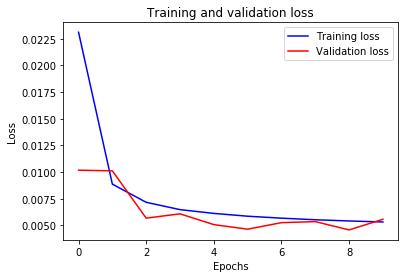

495927/495927 [==============================] - 15s 30us/sample - loss: 0.0063 - mape: 4.3730
test loss : [0.006267993425130051, 4.373038]


In [362]:
model101, x_test101, y_test101, scaler101 = load_and_plot('single_step_10_1_3lstm', 10, 1)

prediction101 = model101.predict(x_test101)
samples, size = prediction101.shape
prediction101 = prediction101.reshape(samples, size//2, 2)
y_test101 = y_test101.reshape(samples, size//2, 2)

In [363]:
show_recursive_traj(19925, x_test101, y_test101, model101, scaler101, 10, 1)

(1, 10, 2)


In [391]:
recursive_metrics(19925, x_test101, y_test101, model101, scaler101, 10, 1)

rmse: tf.Tensor(0.4253995085597143, shape=(), dtype=float64)
mae: tf.Tensor(0.3033028295525085, shape=(), dtype=float64)
mape: tf.Tensor(438.3849713892022, shape=(), dtype=float64)


In [280]:
# x = x_test3010
# y = y_test3010
# lookback = 30
# target = 10

# all_y = []
# all_pred = []
# for idx in range(x.shape[0]):
#     rec_y = generate_targets(y, idx, lookback, target)
#     rec_pred = recursive_prediction(x, model3010, idx, lookback, target)
#     all_y.append(np.array(rec_y).reshape(-1,))
#     all_pred.append(np.array(rec_pred).reshape(-1,))

# np.array(all_y).shape, np.array(all_pred).shape

In [281]:
# np.apply_along_axis(myfunction, axis=1, arr=x_test3010)

In [11]:
def recursive_metrics_all(x, y, model, scaler, lookback, target):
    all_y = []
    all_pred = []
    
    for idx in range(x.shape[0]-target):
        rec_y = generate_targets(y, idx, lookback, target)
        rec_pred = recursive_prediction(x, model, idx, lookback, target)
        mae_score = mae(rec_pred, rec_y)
        rmse_score = rmse(rec_pred, rec_y)
        all_y.append(np.array(rec_y).reshape(1,-1))
        all_pred.append(np.array(rec_pred).reshape(1,-1))
    return all_y, all_pred


X test shape: (485952, 20, 2), y test shape: (485952, 20) 


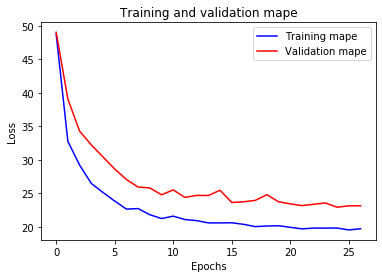

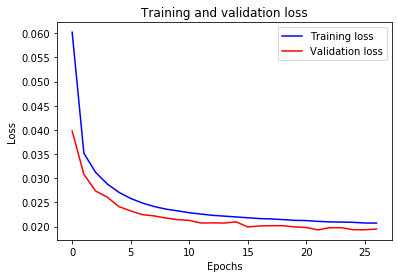

485952/485952 [==============================] - 26s 53us/sample - loss: 0.0234 - mape: 19.6873
test loss : [0.023430506900279396, 19.687346]


In [21]:
model2010, x_test2010, y_test2010, scaler2010 = load_and_plot('retry_multi_step_20_10_3lstm_32', df, 20, 10)

In [22]:
x_test2010.shape[0]

485952

In [46]:
mae_scores = []
rmse_scores = []
mape_scores = []
lookback = 20
target = 10

for idx in range(1000):
    rec_y = generate_targets(y_test2010, idx, lookback, target)
    rec_pred = recursive_prediction(x_test2010, model2010, idx, lookback, target)
    rec_y = np.array(rec_y).reshape(-1,)
    rec_pred = np.array(rec_pred).reshape(-1,)    
    mae_score = mae(rec_pred, rec_y)
    rmse_score = rmse(rec_pred, rec_y)
    mape_score = mape(rec_pred, rec_y)
    mae_scores.append(mae_score.numpy())
    rmse_scores.append(rmse_score.numpy())
    mape_scores.append(mape_score.numpy())
print(np.mean(mae_scores), np.mean(rmse_scores), np.mean(mape_scores))

0.060304184946449284 0.08290973053441231 22.667816874667814


In [35]:
mae_scores[0].numpy()

0.016329295205386278

In [39]:
recursive_metrics(19915, x_test2010, y_test2010, model2010, scaler2010, 20, 10)

rmse: tf.Tensor(0.08335885833946712, shape=(), dtype=float64)
mae: tf.Tensor(0.06286872377243875, shape=(), dtype=float64)
mape: tf.Tensor(11.810250767489086, shape=(), dtype=float64)


In [151]:
filename = [['retry_multi_step_30_30_3lstm_32', 'retry_multi_step_30_10_3lstm_32', 'retry_multi_step_30_1_3lstm_32'], 
            ['retry_multi_step_20_30_3lstm_32', 'retry_multi_step_20_10_3lstm_32', 'retry_multi_step_20_1_3lstm_32'],
            ['retry_multi_step_10_30_3lstm_32', 'retry_multi_step_10_10_3lstm_32', 'retry_multi_step_10_1_3lstm_32']]

In [154]:
filename[0][2]

'retry_multi_step_30_1_3lstm_32'